In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import os

In [98]:
# Load the datasets
games_df = pd.read_csv('../data/games.csv')
users_df = pd.read_csv('../data/users.csv')
recommendations_df = pd.read_csv('../data/recommendations.csv')

In [99]:
print("Missing values in games dataset:")
print(games_df.isnull().sum())
print("Missing values in users dataset:")
print(users_df.isnull().sum())
print("Missing values in recommendations dataset:")
print(recommendations_df.isnull().sum())

Missing values in games dataset:
app_id            0
title             0
date_release      0
win               0
mac               0
linux             0
rating            0
positive_ratio    0
user_reviews      0
price_final       0
price_original    0
discount          0
steam_deck        0
dtype: int64
Missing values in users dataset:
user_id     0
products    0
reviews     0
dtype: int64
Missing values in recommendations dataset:
app_id            0
helpful           0
funny             0
date              0
is_recommended    0
hours             0
user_id           0
review_id         0
dtype: int64


In [102]:
duplicates = recommendations_df.duplicated(subset=['app_id', 'user_id']).sum()
print(f"Number of duplicate recommendations: {duplicates}")

Number of duplicate recommendations: 21


In [103]:
# Assicurati che la colonna 'date' sia in formato datetime
recommendations_df['date'] = pd.to_datetime(recommendations_df['date'])

# Poi, rimuovi i duplicati mantenendo l'ultima occorrenza
recommendations_df = recommendations_df.sort_values(by='date', ascending=False).drop_duplicates(subset=['app_id', 'user_id'], keep='first')

/Users/gianmarconuzzarello/Documents/MLProjects/MLOps/myenv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gianmarconuzzarello/Documents/MLProjects/MLOps/myenv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


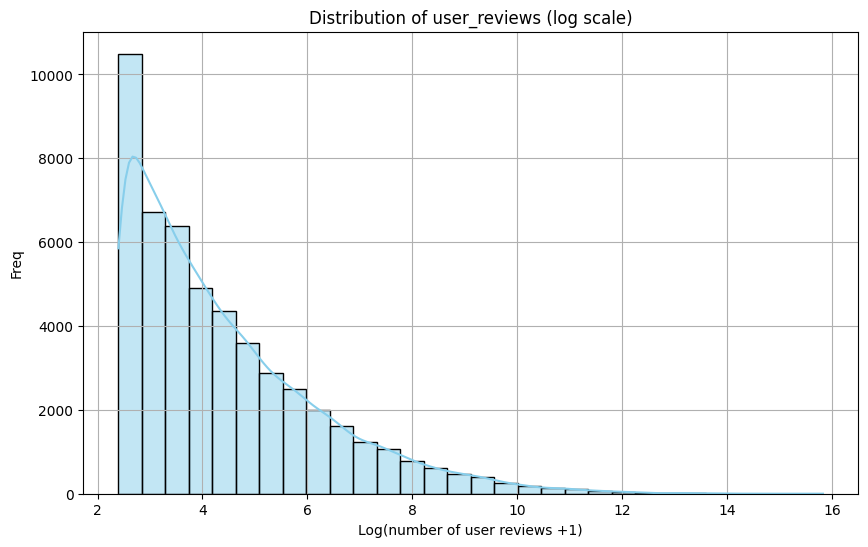

Minimum user reviews: 10
Maximum user reviews: 7494460
Median user reviews: 49.0


In [104]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(games_df["user_reviews"]), bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title("Distribution of user_reviews (log scale)")
plt.xlabel("Log(number of user reviews +1)")
plt.ylabel("Freq")
plt.grid(True)
plt.show()

print("Minimum user reviews:", games_df["user_reviews"].min())
print("Maximum user reviews:", games_df["user_reviews"].max())
print("Median user reviews:", games_df["user_reviews"].median())

In [105]:
recommendations_df.sample(5)

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
37506824,1412190,0,0,2021-10-12,True,27.8,1733082,37506824
21956432,1254120,0,0,2021-08-31,True,63.2,9644165,21956432
12024706,232430,0,0,2018-12-25,True,1.8,14151200,12024706
13496739,213670,0,0,2015-07-17,True,25.6,12271652,13496739
7657118,1237950,0,0,2021-10-31,False,3.3,1202166,7657118


In [106]:
recommendation_stats = recommendations_df.groupby("app_id").agg(
    median_playtime=("hours", "median"),
    proportion_recommended=("is_recommended", lambda x: x.mean())
).reset_index()

In [107]:
recommendation_stats

,app_id,median_playtime,proportion_recommended
0,10,111.4,0.958312
1,20,2.7,0.860177
2,30,8.4,0.897338
3,40,1.1,0.807453
4,50,7.5,0.954943
...,...,...,...
37605,2245890,0.7,0.875000
37606,2246290,2.0,1.000000
37607,2248870,0.0,0.000000
37608,2251240,0.3,0.666667


/Users/gianmarconuzzarello/Documents/MLProjects/MLOps/myenv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gianmarconuzzarello/Documents/MLProjects/MLOps/myenv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


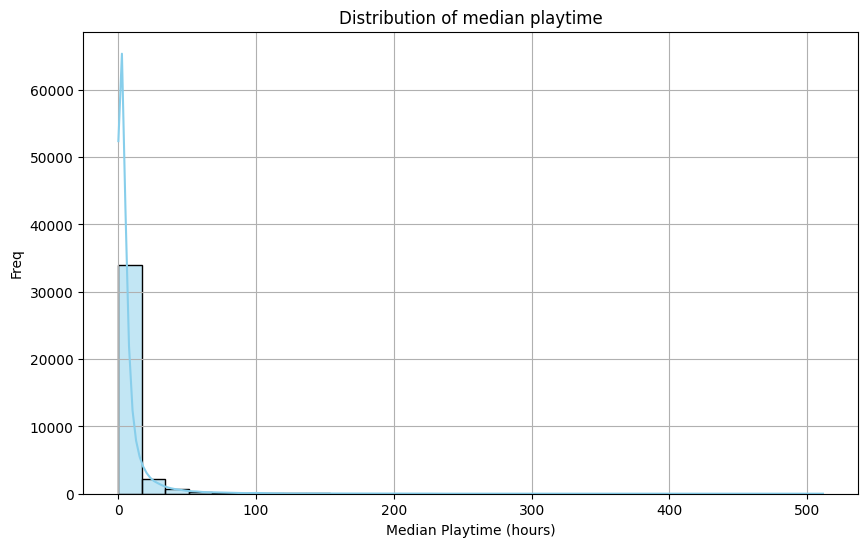

Minimum playtime: 0.0
Maximum playtime: 511.5
Median playtime: 3.0


In [108]:
plt.figure(figsize=(10, 6))
sns.histplot(recommendation_stats["median_playtime"], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title("Distribution of median playtime")
plt.xlabel("Median Playtime (hours)")
plt.ylabel("Freq")
plt.grid(True)
plt.show()

print("Minimum playtime:", recommendation_stats["median_playtime"].min())
print("Maximum playtime:", recommendation_stats["median_playtime"].max())
print("Median playtime:", recommendation_stats["median_playtime"].median())

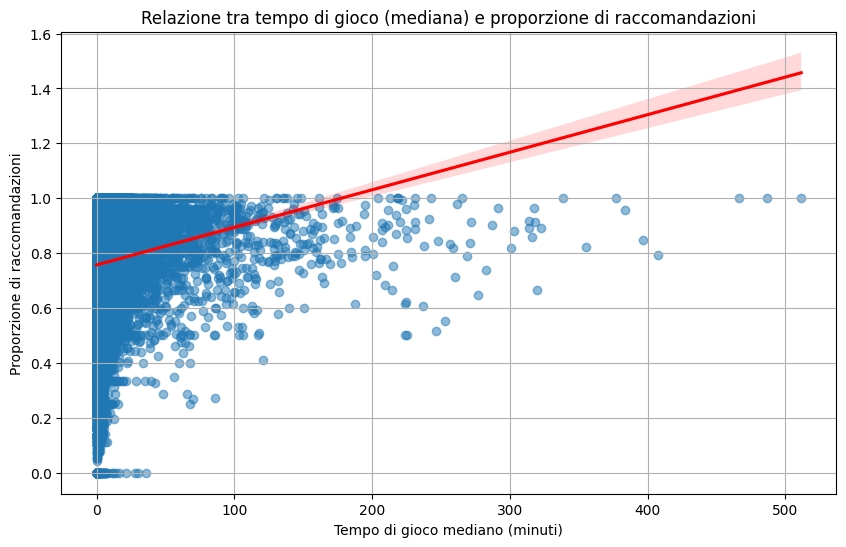

In [109]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=recommendation_stats,
    x="median_playtime",
    y="proportion_recommended",
    scatter_kws={'alpha':0.5},
    line_kws={'color': 'red'}
)

plt.title("Relazione tra tempo di gioco (mediana) e proporzione di raccomandazioni")
plt.xlabel("Tempo di gioco mediano (minuti)")
plt.ylabel("Proporzione di raccomandazioni")
plt.grid(True)
plt.show()

In [110]:
games_df = games_df.merge(
    recommendation_stats,
    how="left",
    left_on="app_id",
    right_on="app_id"
).fillna(0)

Seams like there is a misalignment between the number of user_reviews indicated in the games_df and the number of reviews in the recommendations_df. Starting from now so:

- **We consider only the reviews in recommendations_df**
- We remove games without reviews or without metadata: this because we can't use them to make predictions from a collaborative filtering model neither from a content-based one.

In [111]:
with open('../data/games_metadata.json', 'r') as file:
    metadata = [json.loads(line) for line in file]

# Creare un DataFrame dai metadati
metadata_df = pd.DataFrame(metadata)

# Aggiungere le colonne di metadati al tuo dataframe principale 'games_df'
games_df = games_df.merge(metadata_df[['app_id', 'description', 'tags']], on='app_id', how='left')

In [112]:
games_df

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,median_playtime,proportion_recommended,description,tags
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True,12.9,0.845789,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True,0.0,0.000000,,[Action]
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True,6.9,0.908541,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True,8.1,0.625998,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True,23.4,0.885567,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50867,2296380,I Expect You To Die 3: Cog in the Machine,2023-09-28,True,False,False,Very Positive,96,101,22.00,0.00,0.0,True,0.0,0.000000,,[]
50868,1272080,PAYDAY 3,2023-09-21,True,False,False,Mostly Negative,38,29458,40.00,0.00,0.0,True,0.0,0.000000,,[]
50869,1402110,Eternights,2023-09-11,True,False,False,Very Positive,89,1128,30.00,0.00,0.0,True,0.0,0.000000,,[]
50870,2272250,Forgive Me Father 2,2023-10-19,True,False,False,Very Positive,95,82,17.00,0.00,0.0,True,0.0,0.000000,Embark on a journey into the darkest nightmare...,"[Early Access, FPS, Action, Retro, First-Perso..."


In [113]:
games_to_delete = games_df[
    (games_df['description'].isna() | 
    (games_df['description'] == '')) & 
    (games_df['tags'].isna() | 
    (games_df['tags'].apply(len) == 0)) & 
    ((games_df['median_playtime'] == 0) |
    (games_df['proportion_recommended'] == 0))
]

# Ottieni gli 'app_id' che soddisfano una delle condizioni
missing_app_ids = games_to_delete['app_id'].tolist()

# Visualizza gli 'app_id' che mancano metadata o hanno median_playtime == 0
print("Games to remove:", len(missing_app_ids))

Games to remove: 653


In [ ]:
# Remove from games_df the games with missing metadata or median_playtime == 0
games_df = games_df[~games_df['app_id'].isin(missing_app_ids)]
games_df = games_df.reset_index(drop=True)

In [119]:
# Split the dataset into train and test sets

# Sort the DataFrame by date
recommendations_df = recommendations_df.sort_values(by='date')

cutoff_index = int(len(recommendations_df) * 0.9)
cutoff_date = recommendations_df.iloc[cutoff_index]['date']

train_df = recommendations_df[recommendations_df['date'] <= cutoff_date]
test_df = recommendations_df[recommendations_df['date'] > cutoff_date]


In [120]:
cutoff_date

Timestamp('2022-08-13 00:00:00')

In [121]:
train_df

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
16249835,440,2,0,2010-10-15,True,622.8,11064475,16249835
29871669,7760,11,0,2010-10-15,True,37.7,11294447,29871669
28831996,41100,0,0,2010-10-15,True,15.7,7408951,28831996
18760261,2100,0,0,2010-10-15,True,2.7,9263211,18760261
40837424,6040,0,0,2010-10-15,True,1.0,8447888,40837424
...,...,...,...,...,...,...,...,...
22692141,1313140,0,0,2022-08-13,True,29.0,13087857,22692141
31009780,1139940,0,0,2022-08-13,True,63.3,3688502,31009780
5130045,1313140,0,0,2022-08-13,True,10.2,7381355,5130045
22521477,1313140,0,0,2022-08-13,True,14.6,9647003,22521477


In [136]:
train_df[train_df["user_id"] == 13087857].sort_values(by='app_id', ascending=True).head(10)

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
10893863,70,0,0,2020-03-29,True,6.9,13087857,10893863
36452940,220,0,0,2020-03-27,True,20.2,13087857,36452940
34009157,380,0,0,2020-03-29,True,3.2,13087857,34009157
41071208,400,0,0,2020-02-13,True,6.0,13087857,41071208
34376226,420,0,0,2020-03-29,True,4.5,13087857,34376226
33574240,620,0,0,2020-02-16,True,34.7,13087857,33574240
36428806,3590,0,0,2020-02-11,True,35.2,13087857,36428806
35406780,206440,0,0,2020-04-03,True,3.8,13087857,35406780
10917190,219150,0,0,2022-04-11,True,5.9,13087857,10917190
27077915,246620,0,0,2020-02-08,True,18.1,13087857,27077915


In [122]:
# Percentuali complessive nella colonna originale
print("Distribuzione originale:")
print(recommendations_df['is_recommended'].value_counts(normalize=True) * 100)

# Distribuzione nel train set
print("\nDistribuzione nel train set:")
print(train_df['is_recommended'].value_counts(normalize=True) * 100)

# Distribuzione nel test set
print("\nDistribuzione nel test set:")
print(test_df['is_recommended'].value_counts(normalize=True) * 100)


Distribuzione originale:
is_recommended
True     85.784417
False    14.215583
Name: proportion, dtype: float64

Distribuzione nel train set:
is_recommended
True     85.910848
False    14.089152
Name: proportion, dtype: float64

Distribuzione nel test set:
is_recommended
True     84.6391
False    15.3609
Name: proportion, dtype: float64


In [134]:
directory = '../data/cleaned'

# Controlla se la directory esiste, altrimenti creala
if not os.path.exists(directory):
    os.makedirs(directory)

games_df.to_parquet('../data/cleaned/games_cleaned.parquet', index=False)
test_df.to_parquet('../data/cleaned/test_recommendations.parquet', index=False)
train_df.to_parquet('../data/cleaned/train_recommendations.parquet', index=False)